In [127]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
np.random.seed(54)

# Баланс смещения и дисперсии для интерполяции полиномами разной сложности

**Компромисс отклонение-дисперсия** — это свойство набора моделей предсказания, когда модели с меньшим отклонением от имеющихся данных имеют более высокую дисперсию на новых данных (то есть подвержены переобучению), и наоборот.

**Проблема:** выбираемая модель должна, с одной стороны, *точно уловить все закономерности в обучающих данных*, а с другой стороны — *обобщить закономерности на неизвестных данных*.

- ***Смещение*** — это погрешность оценки, возникающая в результате ошибочного предположения в алгоритме обучения. В результате большого смещения алгоритм может пропустить связь между признаками и выводом (недообучение).

- ***Дисперсия*** — это ошибка чувствительности к малым отклонениям в тренировочном наборе. При высокой дисперсии алгоритм может как-то трактовать случайный шум в тренировочном наборе, а не желаемый результат (переобучение).

In [137]:
def dist_function(x):
    """Ф-я синуса"""
    f_x = np.sin(x)
    return f_x

def gen_data(x):
    """Генерация данных"""
    f_x = dist_function(x)
    b = 0.4
    y = f_x + np.random.uniform(-b, b, len(x))
    sigma = 1/12*(2*b)**2
    return y, f_x, sigma

def get_rand_data(len_ratio, x, y, f_x):
    """Получение рандомных данных"""
    m = len(x)
    m_new = int(np.round(len_ratio*m))
    ind = random.sample(range(m), m_new)
    ind = np.sort(ind)

    x1 = x[ind]
    y1 = y[ind]
    f_x1 = f_x[ind]

    return x1, y1, f_x1

In [ ]:
x_orig = np.arange(0, 4 * np.pi, .2)
y_orig, f_x_orig, sigma = gen_data(x_orig)
p_order = [1, 3, 5, 7, 9, 11]  # степени рассматриваемых полиномов
num_data = 2000  # кол-во объектов в датасете

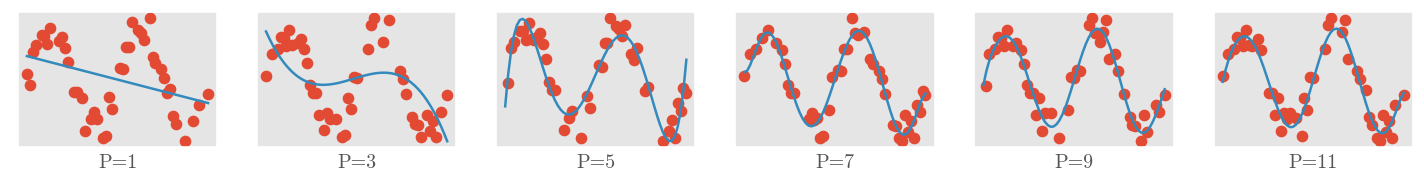

In [145]:
f, ax = plt.subplots(1, len(p_order), figsize=(15, 1.5), dpi=120, facecolor='w', edgecolor='k')
t = np.arange(0.1, 4*np.pi, .2)

P = []  # полиномы
bb = []  # смещения 
vv = []  # дисперсии

for i, p_val in enumerate(p_order):
    exp_f_x = np.zeros(len(t))
    exp_f_x_plot = np.zeros(len(x_orig))
    var = np.zeros(len(t))
    
    for j in range(num_data):
        x, y, f_x = get_rand_data(0.7, x_orig, y_orig, f_x_orig)
        p = np.poly1d(np.polyfit(x, y, p_val))
        P.append(p)
        exp_f_x = exp_f_x + p(t)
        exp_f_x_plot = exp_f_x_plot + p(x_orig)

    exp_f_x = exp_f_x / num_data
    exp_f_x_plot = exp_f_x_plot / num_data
    
    # рисуем интерполяцию
    ax[i].plot(x, y, 'o', x_orig, exp_f_x_plot)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    ax[i].set_xlabel('P=' + str(p_order[i]))
    
    bias = np.linalg.norm(exp_f_x - dist_function(t))  # считаем смещение
    bb.append(bias)

    
    # считаем дисперсию
    for j in range(num_data):
        p_t = P.pop(0)
        var = var + np.square(p_t(t)-exp_f_x)
        
    var = var / num_data
    variance = np.linalg.norm(var)
    vv.append(variance)

In [25]:
print("СМЕЩЕНИЯ")
for i, v in enumerate(bb):
    print(' ', i+1, ':', v)

СМЕЩЕНИЯ
  1 : 5.170207876362785
  2 : 4.75507571553094
  3 : 1.7719774529650676
  4 : 0.535244464843042
  5 : 0.543648242019381
  6 : 1.4177103239610171


In [26]:
print("ДИСПЕРСИИ")
for i, v in enumerate(vv):
    print(' ', i+1, ':', v)

ДИСПЕРСИИ
  1 : 0.04627343133303367
  2 : 0.19358756628384166
  3 : 0.19144510762578906
  4 : 0.08190880858331948
  5 : 1.8631187803803673
  6 : 42.91279239536953


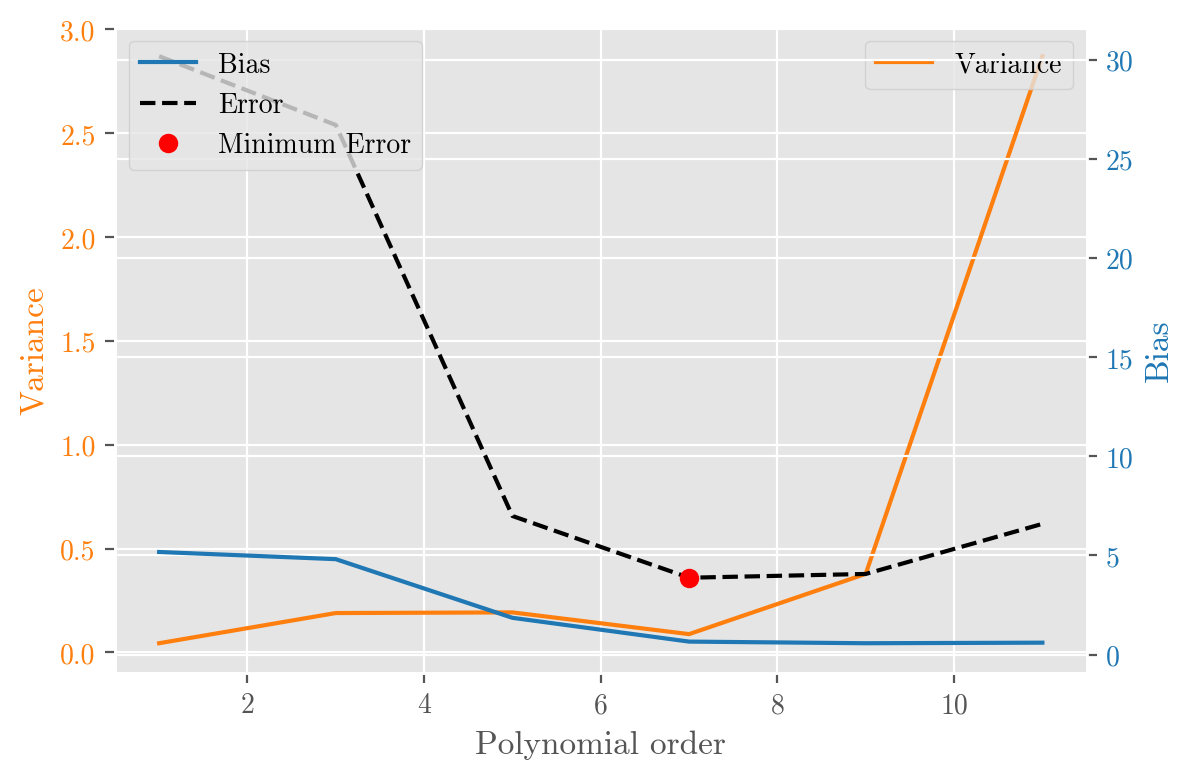

In [167]:
fig, ax1 = plt.subplots(dpi=200)

# график дисперсий
color = 'tab:orange'
ax1.set_xlabel('Polynomial order')  # степень полинома
ax1.set_ylabel('Variance', color=color)  # дисперсия 
ax1.plot(p_order, vv, color=color, label = 'Variance')
ax1.tick_params(axis='y', labelcolor=color)

# график смещений
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Bias', color=color)  # смещение
ax2.plot(p_order, bb, color=color,  label = 'Bias')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# график ошибок
error = np.square(bb) + vv + sigma*len(t)
min_ind = np.argmin(error)  # находим минимальную ошибку

plt.plot(p_order, error, 'k--', label = 'Error')
plt.plot(p_order[min_ind], error[min_ind], 'ro', label= 'Minimum Error')

leg = ax2.legend(loc='upper left')
leg = ax1.legend(loc='upper right')
plt.show()

# Регуляризация (L1 и L2)

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from statistics import mean

In [168]:
df = pd.read_csv('kc_house_data.csv')
 
dropColumns = ['id', 'date', 'zipcode']
df = df.drop(dropColumns, axis = 1)

y = data['price']
X = df.drop('price', axis = 1)
X = np.nan_to_num(X)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

FileNotFoundError: [Errno 2] No such file or directory: 'kc_house_data.csv'

### Building and evaluating the different models

##### Linear Regression

In [85]:
# Building and fitting the Linear Regression model
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
 
# Evaluating the Linear Regression model
print(linearModel.score(X_test, y_test))

0.6897716016381178


##### Ridge(L2) Regression

In [86]:
# List to maintain the different cross-validation scores
cross_val_scores_ridge = []

# List to maintain the different values of alpha
alpha = []

# Loop to compute the different values of cross-validation scores
for i in range(1, 9):
    ridgeModel = Ridge(alpha = i * 0.25)
    ridgeModel.fit(X_train, y_train)
    scores = cross_val_score(ridgeModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(i * 0.25)

# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))


0.25 : 69.09021135727203
0.5 : 69.09038805114042
0.75 : 69.09054500480246
1.0 : 69.09068242413389
1.25 : 69.09080051248868
1.5 : 69.09089946668628
1.75 : 69.09097948253893
2.0 : 69.09104075393401


In [87]:
# Building and fitting the Ridge Regression model
ridgeModelChosen = Ridge(alpha = 2)
ridgeModelChosen.fit(X_train, y_train)

# Evaluating the Ridge Regression model
print(ridgeModelChosen.score(X_test, y_test))

0.6896758797324275


##### Lasso(L1) Regression

In [88]:
# List to maintain the cross-validation scores
cross_val_scores_lasso = []

# List to maintain the different values of Lambda
Lambda = []

# Loop to compute the cross-validation scores
for i in range(1, 9):
    lassoModel = Lasso(alpha = i * 0.25, tol = 0.0925)
    lassoModel.fit(X_train, y_train)
    scores = cross_val_score(lassoModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_lasso.append(avg_cross_val_score)
    Lambda.append(i * 0.25)

# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i]) + ' : ' + str(cross_val_scores_lasso[i]))

0.25 : 69.08464075370239
0.5 : 69.08464616035386
0.75 : 69.0846515380407
1.0 : 69.08465688985346
1.25 : 69.08466221055615
1.5 : 69.08466750993585
1.75 : 69.08467277671033
2.0 : 69.08467802428217


In [89]:
# Building and fitting the Lasso Regression Model
lassoModelChosen = Lasso(alpha = 2, tol = 0.0925)
lassoModelChosen.fit(X_train, y_train)

# Evaluating the Lasso Regression model
print(lassoModelChosen.score(X_test, y_test))

0.6897554836590323


### Comparing and Visualizing the results

In [90]:
# Building the two lists for visualization
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
scores = [linearModel.score(X_test, y_test),
        ridgeModelChosen.score(X_test, y_test),
        lassoModelChosen.score(X_test, y_test)]

# Building the dictionary to compare the scores
mapping = {}
mapping['Linear Regression'] = linearModel.score(X_test, y_test)
mapping['Ridge Regression'] = ridgeModelChosen.score(X_test, y_test)
mapping['Lasso Regression'] = lassoModelChosen.score(X_test, y_test)

# Printing the scores for different models
for key, val in mapping.items():
    print(str(key)+' : '+str(val))

Linear Regression : 0.6897716016381178
Ridge Regression : 0.6896758797324275
Lasso Regression : 0.6897554836590323


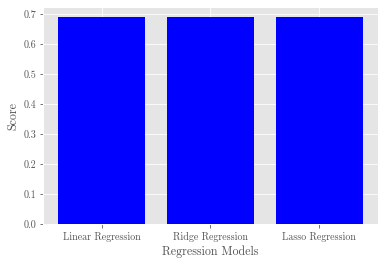

In [94]:
# Plotting the scores
plt.bar(models, scores, color='blue')
plt.xlabel('Regression Models')
plt.ylabel('Score')
plt.show()

## Сингулярное разложение (SVD)

In [98]:
# Singular-value decomposition
from numpy import array
from scipy.linalg import svd

In [95]:
# define a matrix
A = array([[3, 1, 1], [-1, 3, 1]])
print("A=",A)
# SVD
U, S, V_T = svd(A)
# left singular vectors
print("U=")
print(U)
# singular values
print("S=")
print(S)
#right singular vectors
print("V_T=")
print(V_T)

A= [[ 3  1  1]
 [-1  3  1]]
U=
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
S=
[3.46410162 3.16227766]
V_T=
[[-4.08248290e-01 -8.16496581e-01 -4.08248290e-01]
 [-8.94427191e-01  4.47213595e-01  5.26260748e-16]
 [-1.82574186e-01 -3.65148372e-01  9.12870929e-01]]


In [96]:
# Creating S diagonal matrix
S_diag = array([[3.46410162, 0, 0], [0, 3.16227766, 0]])
S_diag

array([[3.46410162, 0.        , 0.        ],
       [0.        , 3.16227766, 0.        ]])

In [97]:
# reconstructing our original matrix A from singular value decomposition elements
# we multiply our matrices from right; that is, the last two matrices are multiplied first, and the result multiplied with the first matrix
B = U.dot(S_diag.dot(V_T))
print("Reconstructed matrix:")
print(B)

Reconstructed matrix:
[[ 3.  1.  1.]
 [-1.  3.  1.]]


# Робастные (надежные) методы

Специфической проблемой с распределением вероятностей переменных при использовании линейной регрессии являются **выбросы**. Это наблюдения, которые находятся далеко за пределами ожидаемого распределения.

Набор данных может иметь выбросы либо по входным переменным, либо по целевой переменной, и обе могут вызвать проблемы для алгоритма линейной регрессии.

Выбросы в наборе данных могут исказить сводную статистику, рассчитанную для переменной, например, среднее значение и стандартное отклонение, что, в свою очередь, может исказить модель в сторону значений выбросов, вдали от центральной массы наблюдений. Это приводит к тому, что модели пытаются сбалансировать хорошие результаты на выбросах и нормальных данных и хуже на обоих в целом.

Вместо этого решение состоит в том, чтобы использовать модифицированные версии линейной регрессии, которые специально учитывают ожидаемые выбросы в наборе данных. Эти методы называются **надежными алгоритмами регрессии** (robust regression algorithms).

In [166]:
from random import random, randint, seed

from numpy import arange

from sklearn.datasets import make_regression

from sklearn.linear_model import LinearRegression  # не робастный метод
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor  # робастные методы

from matplotlib import pyplot

In [155]:
def get_dataset():
    """Подготовка датасета"""
    X, y = make_regression(n_samples=100, n_features=1, tail_strength=0.9, effective_rank=1, n_informative=1, noise=3, bias=50, random_state=1)
    seed(1)  # задает значение генератора случайных чисел, равное x, и возвращает предыдущее значение
    
    for i in range(10):
        factor = randint(2, 4)
        if random() > 0.5:
            X[i] += factor * X.std()
        else:
            X[i] -= factor * X.std()
    return X, y
 
def get_models():
    """Словарь моделей"""
    models = list()
    
    models.append(LinearRegression())
    models.append(HuberRegressor())
    models.append(RANSACRegressor())
    models.append(TheilSenRegressor())
    
    return models
 
def plot_best_fit(X, y, xaxis, model):
    """Отрисовка данных и результатов моделей"""
    model.fit(X, y)  # обучаем модель
    yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))  # предсказываем
    pyplot.plot(xaxis, yaxis, label=type(model).__name__)  # рисуем предсказание

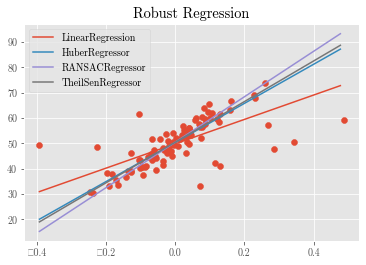

In [156]:
X, y = get_dataset()

xaxis = arange(X.min(), X.max(), 0.01)  # сетка графика

for model in get_models():
    plot_best_fit(X, y, xaxis, model)  # отрисовываем предсказания каждой модели
    
pyplot.scatter(X, y)
pyplot.title('Robust Regression')
pyplot.legend()
pyplot.show()